In [112]:
from hypernetworks.core.Hypernetwork import Hypernetwork
from hypernetworks.core.Hypersimplex import VERTEX, ALPHA, BETA
from hypernetworks.utils.HTCompiler import load_parser, compile_hn
from hypernetworks.utils.HTGraph import draw_hn
from hypernetworks.utils.HTSearch import what_is_it, bottom_up, get_search_paths, top_down
from hypernetworks.utils.HTTools import get_subHn_by_semantic_boundary, get_subHn_by_level

import graphviz

from IPython.display import Image, display
import networkx as nx
import matplotlib.pyplot as plt


parser = load_parser()

pictures_dir = "pictures/graphs/"

In [2]:
def draw_graph(hn, fname, direction="LR", engine="dot"):
    G = graphviz.Digraph(format="png", filename=fname, strict=False, engine=engine,
                         graph_attr={"splines": "spline", "nodesep": "0.5"},
                         node_attr={"shape": "circle"})
    
    G.attr(rankdir=direction)
    G.attr("node", shape="circle", width="0.1", height="0.1", margin="0.1")

    for label, hs in hn.hypernetwork.items():
        if hs.hstype in [ALPHA] and "G" not in hs.R.name:
            directed = "undir" not in hs.R.name
            
            G.edge_attr.update(arrowhead="normal" if directed else "none", arrowsize="0.5")
            G.edge(hs.simplex[0], hs.simplex[1], label=label if directed else "")
    
    G.render()

In [59]:
# def draw_full_graph(hn, fname, direction="LR", engine="dot"):
#     G = graphviz.Graph(format="png", filename=fname, strict=True,
#                        graph_attr={"nodesep": "0.5"},
#                        node_attr={"shape": "circle", "width": "0.1", "height": "0.1", "margin": "0.1"})

#     G.attr(rankdir=direction)
    
#     for label, hs in hn.hypernetwork.items():
#         if hs.hstype in [ALPHA]:
#             for start in hs.simplex:
#                 for end in hs.simplex:
#                     if start != end:
#                         G.edge(start, end)

#     G.render()

In [106]:
def draw_full_graph(hn, fname):
    class GraphVisualization:   
        def __init__(self):
            self.visual = []

        def addEdge(self, a, b):
            temp = [a, b]
            self.visual.append(temp)
            
        def visualise(self, fname):
            G = nx.Graph()
            G.add_edges_from(self.visual)
            nx.draw_networkx(G, edgecolors='black', node_color='white', node_size=1000)
            plt.box(False)
            plt.savefig(fname+".png", format="PNG")
            plt.box(True)
            plt.show()
        
    G = GraphVisualization()
    
    for label, hs in hn.hypernetwork.items():
        if hs.hstype in [ALPHA]:
            for start in hs.simplex:
                for end in hs.simplex:
                    if start != end:
                        G.addEdge(start, end)

    G.visualise(fname)

In [111]:
def draw_hierarchy(hn, fname):
    G = graphviz.Graph(format="png", filename=fname, strict=False)
    
    G.attr("node", shape="none", width="0.5", height="0.01", margin="0.01")
    
    for node, hs in hn.hypernetwork.items():
        if hs.hstype in [ALPHA]:
            for branch in hs.simplex:
                G.edge(node, branch)
    
    G.render()

In [135]:
def draw_NoN(hn, fname):
    def _draw_edge(_G, edge):
        temp_hs = hn.hypernetwork[edge]
                        
        if temp_hs.hstype in [ALPHA]:
            directed = "undir" not in temp_hs.R.name
            _G.edge_attr.update(arrowhead="normal" if directed else "none", arrowsize="0.5")
            _G.edge(temp_hs.simplex[0], temp_hs.simplex[1])
            
    G = graphviz.Digraph(format="png", filename=fname, strict=False, 
                         graph_attr={"splines": "line", "nodesep": "0.8"},
                         node_attr={"shape": "circle"})
    
    G.attr("node", shape="circle")
#     G.attr(rankdir="TB")

    for node, hs in hn.hypernetwork.items():
        if hs.hstype in [ALPHA]:
            if "NoN" in hs.R.name:
                for edge in hs.simplex:
                    _draw_edge(G, edge)
            
            elif "N" in hs.R.name:
                network_name = list(hs.B)[0]

                with G.subgraph(name="cluster_" + network_name, edge_attr={"labelloc": "c", "len": "10"}) as SG:
                    SG.node(network_name, style="invisible", height="0", width="0", label="")
                    SG.attr(label=network_name, rank="same", constraint="false", size='6,6')
                    
                    for edge in hs.simplex:
                        _draw_edge(SG, edge)

    G.render()

In [136]:
def draw_structure(hn, fname):
    temp_hn = Hypernetwork()
    structure_type = 0
    
    for name, hs in hn.hypernetwork.items():
        if "N" in hs.R.name:
            structure_type = 3
            inc = ["dir", "undir", "node", "NoN", "N"]

        elif "G" in hs.R.name:
            structure_type = 3
            inc = ["dir", "undir", "node", "NoN", "G"]
            
        else:
            inc = ["dir", "node"]

    for name, hs in hn.hypernetwork.items():
        if any(x in [hs.R.name] for x in inc):
            temp_hn.insert(name, hstype=hs.hstype, simplex=hs.simplex, R=hs.R, B=hs.B, N=hs.N)

        if structure_type != 3:
            if any(x in [hs.R.name] for x in ["N", "G"]):
                structure_type = 1

            if "H" in hs.R.name:
                structure_type = 2

    if structure_type == 1:
        draw_graph(temp_hn, fname)

    elif structure_type == 2:
        draw_hierarchy(temp_hn, fname)
        
    elif structure_type == 3:
        draw_NoN(temp_hn, fname)

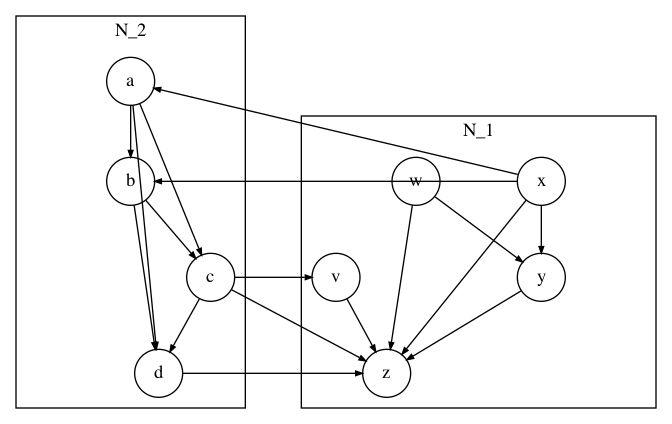

In [141]:
non1_hn = Hypernetwork()

compile_hn(non1_hn, parser, """
    N1=<e1_1=<x, y; R_dir>, e1_2=<x, z; R_dir>, e1_3=<y, z; R_dir>; R_N; B(N_1)>
    N2=<e2_1=<a, b; R_dir>, e2_2=<a, c; R_dir>, e2_3=<a, d; R_dir>, e2_4=<b, c; R_dir>, e2_5=<b, d; R_dir>, e2_6=<c, d; R_dir>; R_N; B(N_2)>
    N3=<e3_1=<w, y; R_dir>, e3_2=<w, z; R_dir>, e3_3=<v, z; R_dir>; R_N; B(N_1)>
    NoN=<e_1=<x, a; R_dir>, e_2=<x, b; R_dir>, e_3=<d, z; R_dir>, e_4=<c, z; R_dir>, e_5=<c, v; R_dir>; R_NoN>
""")

draw_structure(non1_hn, pictures_dir+"non")
Image(filename=pictures_dir+"non.png", width=600)

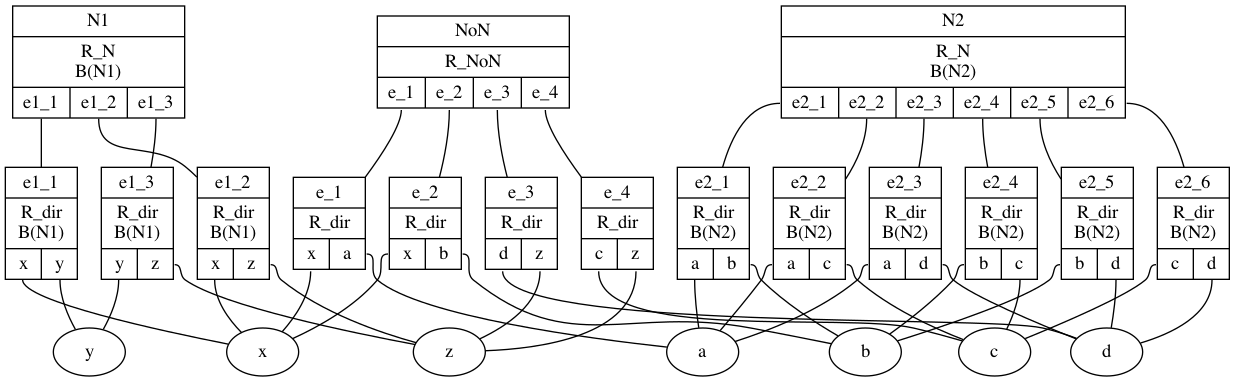

In [9]:
draw_hn(non1_hn, fname=pictures_dir+"non-hn", view=False, split_camel=False, direction="TB")
Image(filename=pictures_dir+"non-hn.png", width=1000, height=300)

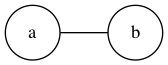

In [10]:
graph1_hn = Hypernetwork()

compile_hn(graph1_hn, parser, """
    x=<a, b; R_undir>
""")

draw_graph(graph1_hn, pictures_dir+"graph1")
Image(filename=pictures_dir+"graph1.png", width=200)

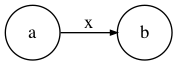

In [11]:
graph2_hn = Hypernetwork()

compile_hn(graph2_hn, parser, """
    x=<a, b; R_dir>
""")

draw_graph(graph2_hn, pictures_dir+"graph2")
Image(filename=pictures_dir+"graph2.png", width=200)

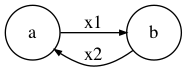

In [12]:
graph3_hn = Hypernetwork()

compile_hn(graph3_hn, parser, """
    x1=<a, b; R_dir>
    x2=<b, a; R_dir>
""")

draw_graph(graph3_hn, pictures_dir+"graph3")
Image(filename=pictures_dir+"graph3.png", width=200)

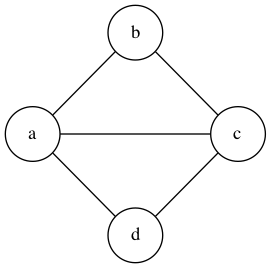

In [13]:
graph4_hn = Hypernetwork()

compile_hn(graph4_hn, parser, """
    G=< x_1=<a, b; R_undir>,
        x_2=<a, c; R_undir>,
        x_3=<a, d; R_undir>,
        x_4=<b, c; R_undir>,
        x_5=<d, c; R_undir>; R_G>
""")

draw_graph(graph4_hn, pictures_dir+"graph4")
Image(filename=pictures_dir+"graph4.png", width=300)

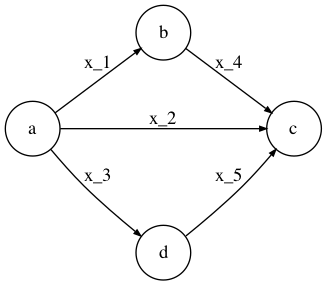

In [14]:
graph5_hn = Hypernetwork()

compile_hn(graph5_hn, parser, """
    G=< x_1=<a, b; R_dir>,
        x_2=<a, c; R_dir>,
        x_3=<a, d; R_dir>,
        x_4=<b, c; R_dir>,
        x_5=<d, c; R_dir>; R_G>
""")

draw_graph(graph5_hn, pictures_dir+"graph5")
Image(filename=pictures_dir+"graph5.png", width=300)

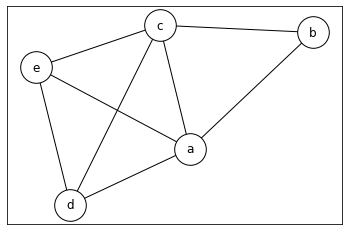

In [115]:
graph_union_hn = Hypernetwork()

compile_hn(graph_union_hn, parser, """
    G_1=<a, b, c; R_undir>
	G_2=<a, c, d, e; R_undir>
""")

draw_full_graph(graph_union_hn, pictures_dir+"graph6")
# Image(filename=pictures_dir+"graph6.png", width=400)

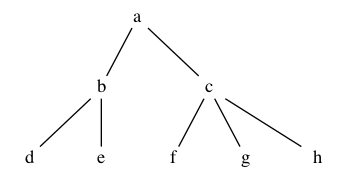

In [15]:
hierarchy1_hn = Hypernetwork()

compile_hn(hierarchy1_hn, parser, """
    H=< a=<b, c; R_node>,
        b=<d, e; R_node>,
        c=<f, g, h; R_node>; R_H>
""")

draw_structure(hierarchy1_hn, pictures_dir+"hierarchy1-hn")
Image(filename=pictures_dir+"hierarchy1-hn.png", width=400)

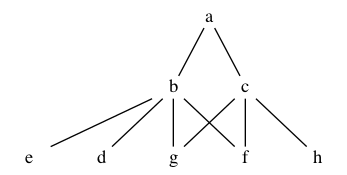

In [16]:
hierarchy2_hn = Hypernetwork()

compile_hn(hierarchy2_hn, parser, """
    H=< a=<b, c; R_node>,
        b=<d, e, f, g; R_node>,
        c=<f, g, h; R_node>; R_H>
""")

draw_structure(hierarchy2_hn, pictures_dir+"hierarchy2-hn")
Image(filename=pictures_dir+"hierarchy2-hn.png", width=400)

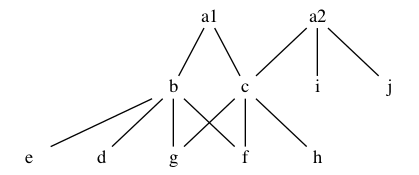

In [17]:
heterarchy1_hn = Hypernetwork()

compile_hn(heterarchy1_hn, parser, """
    H=< a1=<b, c; R_node>,
        a2=<c, i, j; R_node>,
        b=<d, e, f, g; R_node>,
        c=<f, g, h; R_node>; R_H>
""")

draw_structure(heterarchy1_hn, pictures_dir+"heterarchy1-hn")
Image(filename=pictures_dir+"heterarchy1-hn.png", width=450)

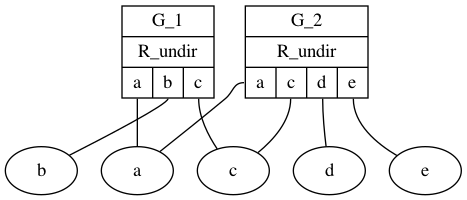

In [33]:
draw_hn(graph_union_hn, fname=pictures_dir+"graph-union-hn", view=False, split_camel=False, direction="TB")
Image(filename=pictures_dir+"graph-union-hn.png", width=400)